<a href="https://colab.research.google.com/github/Taedriel/ZSL-v2/blob/googleImageFSL/pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install selenium
!pip install -U sklearn
!pip install scikit-learn-intelex
!pip install easyfsl
!pip install Pillow
!pip install pyod

!cd "./drive/MyDrive/Colab Notebooks/pipeline" && pip install -r requirements.txt

!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')

In [2]:
!sudo apt install python3-sklearn 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-sklearn is already the newest version (0.19.1-3).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 67 not upgraded.


In [3]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, itertools, shutil, requests, webbrowser, urllib.request, time, random
import PIL.Image
from IPython.core.display import Image

from selenium import webdriver
from bs4 import BeautifulSoup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision import utils
from torchvision.datasets import Omniglot
from torchvision.models import resnet18
from torch.autograd import Variable
import torch.nn.functional as F

from tqdm import tqdm
%matplotlib inline

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [4]:
if not open("/content/drive/MyDrive/Colab Notebooks/pipeline/model/resnet18_with_pretraining.tar", "r"):
  os.system('wget https://public-sicara.s3.eu-central-1.amazonaws.com/easy-fsl/resnet18_with_pretraining.tar')

In [5]:
PATH = "/content/drive/MyDrive/Colab Notebooks/pipeline/"
PATH_IMAGES = "/content/drive/MyDrive/Colab Notebooks/pipeline/images/"
PATH_MODEL = "/content/drive/MyDrive/Colab Notebooks/pipeline/model/"

globalSize = 20
LEN_FOR_ONE_SCROLL = 20
retreivalNotDone = False
trainingNeeded = False

In [6]:
def createClasses(classesFile):

  classes = ""
  classesTr = []
  classesTe = []
  classeForSimilarity = []
  index=0

  for animal in classesFile.readlines():

    animal = animal.strip("\n").replace(" ", "")
    if animal!="list":
      classes+=animal+", "

      if index%2:
        classesTe.append(animal)
      else:
        classesTr.append(animal)
      index+=1

  ridx = random.randint(0, len(classesTe)-1)
  classeForSimilarity.append(classesTe[ridx])
  classesTe.remove(classeForSimilarity[0])

  print("training / testing :", classesTr[0:5])

  return classes, classesTr[0:5], classesTe, classeForSimilarity

In [7]:
classesFile = open(PATH_MODEL+"animals.txt")
classes, classesTr, _, i = createClasses(classesFile)

training / testing : ['Aardvark', 'Africanbuffalo', 'Africanleopard', 'Alligator', 'Americanrobin']


--- IMAGE RETRIEVAL ---

In [8]:
"""
thumbnail / jpg (compression) may be an issue
"""

def getParser(classeName):

  site = 'https://www.google.com/search?tbm=isch&q='+classeName

  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')

  driver = webdriver.Chrome('chromedriver', options=chrome_options)
  driver.get(site)
  driver.execute_script("window.scrollBy(0, document.body.scrollHeight)")
  soup = BeautifulSoup(driver.page_source, 'html.parser')
  driver.close()

  return soup


def getClassesImagesURLLIB():

  imagesNumber = 0

  shutil.rmtree(PATH_IMAGES, ignore_errors=False)
  os.makedirs(PATH_IMAGES)

  for classe in classes.split(","):

    try:
      classeName = classe.replace(" ", "")
      os.makedirs(PATH_IMAGES+classeName)

      soup = getParser(classeName)
      img_tags = soup.find_all("img", class_="rg_i")
      for index in range(0, len(img_tags)):
        try:
            urllib.request.urlretrieve(img_tags[index]['src'], PATH_IMAGES+classeName+"/"+str(classeName+str(index))+".jpg")
            imagesNumber+=1
        except Exception as e:
            pass
    except:
      pass

  print(str(imagesNumber) + " images were downloaded. " + str(imagesNumber/len(classes.split(","))) + " per classes")

In [9]:
if retreivalNotDone:
  getClassesImagesURLLIB()
  retreivalNotDone = False

--- DATASETS ---

In [10]:
image_size = 28

# NB: background=True selects the train set, background=False selects the test set
# It's the nomenclature from the original paper, we just have to deal with it

train_set = Omniglot(
    root="/content/drive/MyDrive/Colab Notebooks/pipeline/model/dataO",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=False,
)
test_set = Omniglot(
    root="/content/drive/MyDrive/Colab Notebooks/pipeline/model/dataO",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=False,
)

In [ ]:
N_WAY = 5  # Number of classes in a task
N_SHOT = 5  # Number of images per class in the support set
N_QUERY = 10  # Number of images per class in the query set
N_EVALUATION_TASKS = 100

N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100

train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

# The sampler needs a dataset with a "get_labels" method. Check the code if you have any doubt!
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


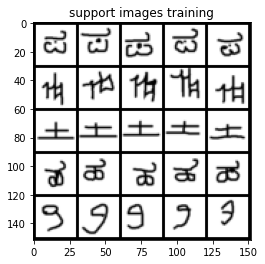

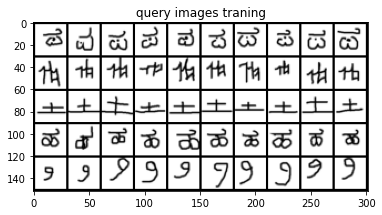

In [12]:
(example_support_images,
example_support_labels,
example_query_images,
example_query_labels,
example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images training", images_per_row=N_SHOT)
plot_images(example_query_images, "query images traning", images_per_row=N_QUERY)

In [13]:
%cd "/content/drive/MyDrive/Colab Notebooks/pipeline/model/"

/content/drive/MyDrive/Colab Notebooks/pipeline/model


In [39]:
from easyfsl.datasets import CUB

N_WAY = 5  # Number of classes in a task
N_SHOT = 20  # Number of images per class in the support set
N_QUERY = 1  # Number of images per class in the query set
N_TRAINING_EPISODES = 40000
N_VALIDATION_TASKS = 100
N_EVALUATION_TASKS = 100

train_set = CUB(split="train", training=True)
test_set = CUB(split="test", training=False)

train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

test_sampler = TaskSampler(
    test_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


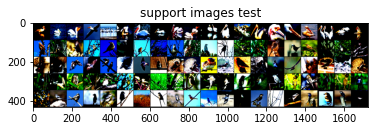

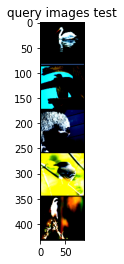

In [32]:
(example_support_images,
example_support_labels,
example_query_images,
example_query_labels,
example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images test", images_per_row=N_SHOT)
plot_images(example_query_images, "query images test", images_per_row=N_QUERY)

--- PROTOTYPICAL NETWORK ---

In [16]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(self, support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor,) -> torch.Tensor:
        """
        Predict query labels using labeled support images.
        """
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        n_way = len(torch.unique(support_labels))
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )

        dists = torch.cdist(z_query, z_proto)
        scores = -dists
        #print("d(query, prototype) = ", dists)
        return scores


convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network) #.cuda()

In [17]:
# those two followings are the meta training

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def fit(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor,) -> float:
    optimizer.zero_grad()
    classification_scores = model(support_images, support_labels, query_images)
    #support_images.cuda(), support_labels.cuda(), query_images.cuda()

    loss = criterion(classification_scores, query_labels) #query_labels.cuda()
    loss.backward()
    optimizer.step()

    return loss.item()

def trainOnSet(datasetL):
  log_update_frequency = 10
  all_loss = []
  model.train()

  # training here, tqdm is for the progress bar
  with tqdm(enumerate(datasetL), total=len(datasetL)) as tqdm_train:
      for episode_index, (support_images, support_labels, query_images, query_labels, _,) in tqdm_train:
          loss_value = fit(support_images, support_labels, query_images, query_labels)
          all_loss.append(loss_value)

          if episode_index % log_update_frequency == 0:
              tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

  torch.save(model.state_dict(), PATH_MODEL+"proto_model.pt")

In [18]:
def getCUBClassesForATask(label_ids, class_ids, classNames):
  carac = [""]*N_WAY
  previousLen = 0

  for i in range(0, N_WAY):

    labelI = label_ids[i*N_SHOT]
    name = classNames[class_ids[labelI]]
    try:
      firstName, lastName = name.split(".")[1].split("/")[-1].split("_")[0:2]
      carac[labelI] = firstName[0:2]+lastName[0:2]
    except:
      abreviation = name.split(".")[1][0:2]
      carac[labelI] = abreviation

    
  return carac

classesList = lambda i, label_ids, class_ids, classesNames: getCUBClassesForATask(label_ids, class_ids, classesNames)[i]

def printConfusionMatrix(confM, label_ids, class_ids, classNames):

  print("\n")
  print("A/P \t", end="")

  for i in range(0, len(confM)):
    print(classesList(i, label_ids, class_ids, classNames) + "\t", end="")

  print("\n")
  for i in range(0, len(confM)):
    c_name = classesList(i, label_ids, class_ids, classNames)
    print(f"{c_name:8}", end="")
    for j in range(0, len(confM[0])):
      print(str(confM[i][j]) + "\t", end="")
    print("\n")

In [19]:
#suppr les cuda sur examples
#prediction on one support

if trainingNeeded:
  trainOnSet(train_loader)

model.eval()
example_scores = model(
    example_support_images,
    example_support_labels,
    example_query_images,
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)
classNames = test_set.class_names

confM = [
         [0 for i in range(0, N_WAY)] for j in range (0, N_WAY)
        ]
accuracy = 0

for i in range(len(example_query_labels)):
  print(f"{classNames[example_class_ids[example_query_labels[i]]]} / {classNames[example_class_ids[example_predicted_labels[i]]]}")
  
  if classNames[example_class_ids[example_query_labels[i]]] == classNames[example_class_ids[example_predicted_labels[i]]]:
    accuracy+=1
  
  k = example_query_labels[i]
  l = example_predicted_labels[i]
  confM[k][l]+=1

printConfusionMatrix(confM, example_support_labels, example_class_ids, classNames)
print("accuracy for this task : ", accuracy/len(example_query_labels)*100, "%")

085.Horned_Lark / 163.Cape_May_Warbler
085.Horned_Lark / 085.Horned_Lark
085.Horned_Lark / 169.Magnolia_Warbler
085.Horned_Lark / 085.Horned_Lark
085.Horned_Lark / 085.Horned_Lark
085.Horned_Lark / 085.Horned_Lark
085.Horned_Lark / 085.Horned_Lark
085.Horned_Lark / 169.Magnolia_Warbler
085.Horned_Lark / 169.Magnolia_Warbler
085.Horned_Lark / 085.Horned_Lark
163.Cape_May_Warbler / 122.Harris_Sparrow
163.Cape_May_Warbler / 169.Magnolia_Warbler
163.Cape_May_Warbler / 163.Cape_May_Warbler
163.Cape_May_Warbler / 169.Magnolia_Warbler
163.Cape_May_Warbler / 169.Magnolia_Warbler
163.Cape_May_Warbler / 169.Magnolia_Warbler
163.Cape_May_Warbler / 085.Horned_Lark
163.Cape_May_Warbler / 169.Magnolia_Warbler
163.Cape_May_Warbler / 163.Cape_May_Warbler
163.Cape_May_Warbler / 085.Horned_Lark
030.Fish_Crow / 030.Fish_Crow
030.Fish_Crow / 085.Horned_Lark
030.Fish_Crow / 030.Fish_Crow
030.Fish_Crow / 030.Fish_Crow
030.Fish_Crow / 030.Fish_Crow
030.Fish_Crow / 030.Fish_Crow
030.Fish_Crow / 030.Fish_Crow


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/pipeline/model/resnet18_with_pretraining.tar", map_location="cpu"))

In [34]:
cuda = False

def createConfusionMatrix(model, support_images, support_labels, query_images):

  confusionMatrix =[
         [0 for i in range(0, N_WAY)] for j in range (0, N_WAY)
        ]

  example_scores = model(
    support_images,
    support_labels,
    query_images,
    ).detach()

  _, example_predicted_labels = torch.max(example_scores.data, 1)

  for i in range(len(example_query_labels)):
    
    k = example_query_labels[i]
    l = example_predicted_labels[i]
    confusionMatrix[k][l]+=1

  return confusionMatrix

def evaluate_on_one_task(support_images: torch.Tensor, support_labels: torch.Tensor, query_images: torch.Tensor, query_labels: torch.Tensor,) -> [int, int]:
  
    """
    Returns the number of correct predictions of query labels, and the total number of predictions.
    """

    confusionMatrixI = createConfusionMatrix(model, support_images, support_labels, query_images)

    if cuda:

      return (
        torch.max(
            model(
            support_images.cuda(),
            support_labels.cuda(),
            query_images.cuda(),
            ).detach().data,
            1,
        )[1] == query_labels.cuda()).sum().item(), len(query_labels), confusionMatrixI

    else:

      return (
        torch.max(
            model(
            support_images,
            support_labels,
            query_images,
            ).detach().data,
            1,
        )[1] == query_labels).sum().item(), len(query_labels), confusionMatrixI

def evaluate(data_loader: DataLoader):
    # We'll count everything and compute the ratio at the end
    total_predictions = 0
    correct_predictions = 0
    confusionMatrix = np.array([
            [0 for i in range(0, N_WAY)] for j in range (0, N_WAY)
            ])
    classNames = test_set.class_names
    confMAccuracy = []

    
    # eval mode affects the behaviour of some layers (such as batch normalization or dropout)
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (support_images, support_labels, query_images, query_labels, class_ids,) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total, confusionMatrixI = evaluate_on_one_task(support_images, support_labels, query_images, query_labels)
            total_predictions += total
            correct_predictions += correct
            confMAccuracy.append(np.trace(confusionMatrixI)/(np.sum(confusionMatrixI)-np.trace(confusionMatrixI)))

            printConfusionMatrix(confusionMatrixI, support_labels, class_ids, classNames)

    print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")
    print(f"Model tested on {len(data_loader)} tasks. Accuracy for confusion matrix: {(100 * sum(confMAccuracy)/len(confMAccuracy)):.2f}%")

In [40]:
evaluate(test_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  1%|          | 1/100 [00:18<30:57, 18.77s/it]



A/P 	BrCr	RiKi	HaSp	LeTe	CaWr	

BrCr    0	1	0	0	0	

RiKi    0	0	0	0	1	

HaSp    0	0	0	1	0	

LeTe    0	1	0	0	0	

CaWr    0	0	0	0	1	



  2%|▏         | 2/100 [00:21<15:37,  9.56s/it]



A/P 	LeFl	HaSp	Whth	KeWa	MaWa	

LeFl    0	0	1	0	0	

HaSp    0	0	0	1	0	

Whth    0	0	0	0	1	

KeWa    0	0	0	0	1	

MaWa    0	1	0	0	0	



  3%|▎         | 3/100 [00:24<10:40,  6.60s/it]



A/P 	RhAu	LeFl	Ga	Whbr	MaWa	

RhAu    0	1	0	0	0	

LeFl    0	0	1	0	0	

Ga      0	0	0	1	0	

Whbr    1	0	0	0	0	

MaWa    0	0	0	0	1	



  4%|▍         | 4/100 [00:28<08:20,  5.22s/it]



A/P 	HoLa	Whbr	WhPe	CaGl	ClSw	

HoLa    0	1	0	0	0	

Whbr    0	0	1	0	0	

WhPe    0	0	0	1	0	

CaGl    1	0	0	0	0	

ClSw    1	0	0	0	0	



  5%|▌         | 5/100 [00:31<07:02,  4.45s/it]



A/P 	Yebr	FiCr	HaSp	KeWa	MoWa	

Yebr    0	0	0	0	1	

FiCr    0	0	1	0	0	

HaSp    0	0	0	1	0	

KeWa    1	0	0	0	0	

MoWa    0	1	0	0	0	



  6%|▌         | 6/100 [00:34<06:15,  3.99s/it]



A/P 	RiKi	HoLa	HaSp	Whth	BeWr	

RiKi    0	0	0	0	1	

HoLa    0	0	1	0	0	

HaSp    1	0	0	0	0	

Whth    0	1	0	0	0	

BeWr    0	1	0	0	0	



  7%|▋         | 7/100 [00:37<05:43,  3.70s/it]



A/P 	BrCr	FiCr	PuFi	KeWa	MaWa	

BrCr    0	0	0	1	0	

FiCr    1	0	0	0	0	

PuFi    0	0	0	0	1	

KeWa    0	0	0	0	1	

MaWa    0	1	0	0	0	



  8%|▊         | 8/100 [00:40<05:22,  3.50s/it]



A/P 	NoFu	Ga	RiKi	HoLa	ClSw	

NoFu    0	0	0	1	0	

Ga      1	0	0	0	0	

RiKi    1	0	0	0	0	

HoLa    0	0	1	0	0	

ClSw    0	1	0	0	0	



  9%|▉         | 9/100 [00:43<05:07,  3.37s/it]



A/P 	RhAu	PuFi	Ga	Sa	CaMa	

RhAu    0	0	1	0	0	

PuFi    0	0	0	1	0	

Ga      0	0	0	0	1	

Sa      0	1	0	0	0	

CaMa    0	0	0	0	1	



 10%|█         | 10/100 [00:46<04:56,  3.30s/it]



A/P 	Ga	RiKi	HoSp	SeSp	KeWa	

Ga      0	0	0	0	1	

RiKi    0	1	0	0	0	

HoSp    0	0	0	1	0	

SeSp    0	0	0	1	0	

KeWa    0	1	0	0	0	



 11%|█         | 11/100 [00:49<04:47,  3.23s/it]



A/P 	Yebr	LeTe	KeWa	BeWr	CaWr	

Yebr    1	0	0	0	0	

LeTe    0	0	0	0	1	

KeWa    0	0	0	1	0	

BeWr    0	0	0	1	0	

CaWr    0	0	0	1	0	



 12%|█▏        | 12/100 [00:52<04:40,  3.19s/it]



A/P 	FiCr	RiKi	GrGr	SeSp	KeWa	

FiCr    0	0	0	0	1	

RiKi    0	0	0	1	0	

GrGr    0	0	0	1	0	

SeSp    1	0	0	0	0	

KeWa    0	0	0	1	0	



 13%|█▎        | 13/100 [00:55<04:35,  3.17s/it]



A/P 	RhAu	GrGr	HaSp	ClSw	BeWr	

RhAu    0	0	1	0	0	

GrGr    1	0	0	0	0	

HaSp    0	0	1	0	0	

ClSw    0	0	0	0	1	

BeWr    0	1	0	0	0	



 14%|█▍        | 14/100 [00:59<04:30,  3.14s/it]



A/P 	BrCr	RiKi	HaSp	Whth	BeWr	

BrCr    0	0	0	1	0	

RiKi    1	0	0	0	0	

HaSp    0	1	0	0	0	

Whth    1	0	0	0	0	

BeWr    0	0	0	0	1	



 15%|█▌        | 15/100 [01:02<04:25,  3.12s/it]



A/P 	BrBl	HoSp	ClSw	LeTe	CaMa	

BrBl    0	0	0	0	1	

HoSp    0	1	0	0	0	

ClSw    0	0	0	0	1	

LeTe    0	0	0	0	1	

CaMa    0	0	1	0	0	



 16%|█▌        | 16/100 [01:05<04:21,  3.11s/it]



A/P 	BrCr	LeFl	NoFu	Ga	MaWa	

BrCr    0	0	0	1	0	

LeFl    1	0	0	0	0	

NoFu    0	0	0	0	1	

Ga      0	0	1	0	0	

MaWa    0	1	0	0	0	



 17%|█▋        | 17/100 [01:08<04:18,  3.12s/it]



A/P 	FiCr	Whbr	WhPe	HoSp	Whth	

FiCr    0	0	0	0	1	

Whbr    0	1	0	0	0	

WhPe    0	0	1	0	0	

HoSp    1	0	0	0	0	

Whth    0	0	0	0	1	



 18%|█▊        | 18/100 [01:11<04:15,  3.11s/it]



A/P 	LaBu	NoFu	HoLa	HoSp	Whth	

LaBu    0	0	0	1	0	

NoFu    0	1	0	0	0	

HoLa    0	0	1	0	0	

HoSp    0	0	0	0	1	

Whth    1	0	0	0	0	



 19%|█▉        | 19/100 [01:14<04:11,  3.10s/it]



A/P 	Ga	GrGr	HoSp	CaMa	CaWr	

Ga      0	0	0	1	0	

GrGr    0	0	0	1	0	

HoSp    1	0	0	0	0	

CaMa    0	0	1	0	0	

CaWr    0	0	0	1	0	



 20%|██        | 20/100 [01:17<04:08,  3.11s/it]



A/P 	RhAu	BrBl	BrCr	Ga	LeTe	

RhAu    0	0	0	1	0	

BrBl    0	0	1	0	0	

BrCr    1	0	0	0	0	

Ga      0	0	1	0	0	

LeTe    0	0	1	0	0	



 21%|██        | 21/100 [01:20<04:05,  3.11s/it]



A/P 	HoSp	LeTe	Grta	MaWa	MoWa	

HoSp    0	0	0	0	1	

LeTe    1	0	0	0	0	

Grta    0	0	0	0	1	

MaWa    0	1	0	0	0	

MoWa    0	0	1	0	0	



 22%|██▏       | 22/100 [01:23<04:03,  3.12s/it]



A/P 	HoSp	HaSp	Grta	MaWa	MoWa	

HoSp    1	0	0	0	0	

HaSp    0	0	0	0	1	

Grta    0	1	0	0	0	

MaWa    0	0	0	0	1	

MoWa    0	0	0	1	0	



 23%|██▎       | 23/100 [01:26<04:00,  3.12s/it]



A/P 	RiKi	GrGr	SeSp	Whth	KeWa	

RiKi    0	0	0	1	0	

GrGr    1	0	0	0	0	

SeSp    0	0	1	0	0	

Whth    0	0	1	0	0	

KeWa    0	0	0	0	1	



 24%|██▍       | 24/100 [01:30<03:57,  3.12s/it]



A/P 	LaBu	BrCr	HoLa	HaSp	CaGl	

LaBu    0	0	0	0	1	

BrCr    1	0	0	0	0	

HoLa    0	0	0	1	0	

HaSp    0	0	1	0	0	

CaGl    0	1	0	0	0	



 25%|██▌       | 25/100 [01:33<03:53,  3.11s/it]



A/P 	BrCr	GrGr	SeSp	LeTe	KeWa	

BrCr    0	0	0	1	0	

GrGr    0	0	0	0	1	

SeSp    0	0	0	1	0	

LeTe    1	0	0	0	0	

KeWa    1	0	0	0	0	



 26%|██▌       | 26/100 [01:36<03:49,  3.11s/it]



A/P 	FiCr	SeSp	Whth	MaWa	MoWa	

FiCr    0	0	0	1	0	

SeSp    0	0	0	0	1	

Whth    1	0	0	0	0	

MaWa    0	0	0	1	0	

MoWa    0	0	1	0	0	



 27%|██▋       | 27/100 [01:39<03:46,  3.10s/it]



A/P 	PuFi	HoSp	HaSp	SeSp	Grta	

PuFi    0	0	0	0	1	

HoSp    0	0	0	1	0	

HaSp    0	0	1	0	0	

SeSp    1	0	0	0	0	

Grta    0	1	0	0	0	



 28%|██▊       | 28/100 [01:42<03:43,  3.11s/it]



A/P 	RhAu	GrGr	CaGl	ClSw	CaWr	

RhAu    1	0	0	0	0	

GrGr    0	0	0	0	1	

CaGl    0	0	0	0	1	

ClSw    0	0	0	0	1	

CaWr    0	0	1	0	0	



 29%|██▉       | 29/100 [01:45<03:40,  3.10s/it]



A/P 	NoFu	HoLa	WhPe	SeSp	Whth	

NoFu    0	1	0	0	0	

HoLa    0	0	0	1	0	

WhPe    0	0	0	0	1	

SeSp    0	0	1	0	0	

Whth    1	0	0	0	0	



 30%|███       | 30/100 [01:48<03:37,  3.11s/it]



A/P 	BrBl	RiKi	Sa	SeSp	LeTe	

BrBl    0	0	0	1	0	

RiKi    1	0	0	0	0	

Sa      0	1	0	0	0	

SeSp    0	0	1	0	0	

LeTe    0	0	0	0	1	



 31%|███       | 31/100 [01:51<03:35,  3.12s/it]



A/P 	RhAu	LaBu	FiCr	ClSw	KeWa	

RhAu    1	0	0	0	0	

LaBu    0	1	0	0	0	

FiCr    0	0	1	0	0	

ClSw    0	0	0	0	1	

KeWa    0	0	0	1	0	



 32%|███▏      | 32/100 [01:55<03:33,  3.14s/it]



A/P 	Yebr	BrCr	FiCr	Ga	SeSp	

Yebr    1	0	0	0	0	

BrCr    0	0	0	1	0	

FiCr    0	0	0	1	0	

Ga      0	1	0	0	0	

SeSp    0	0	1	0	0	



 33%|███▎      | 33/100 [01:58<03:29,  3.13s/it]



A/P 	Ga	RiKi	HoLa	Sa	Grta	

Ga      0	0	0	0	1	

RiKi    0	0	0	1	0	

HoLa    0	0	0	0	1	

Sa      0	1	0	0	0	

Grta    1	0	0	0	0	



 34%|███▍      | 34/100 [02:01<03:26,  3.13s/it]



A/P 	PuFi	Whbr	HoSp	Whth	MoWa	

PuFi    0	0	0	1	0	

Whbr    0	1	0	0	0	

HoSp    0	0	0	1	0	

Whth    0	0	0	1	0	

MoWa    0	0	0	1	0	



 35%|███▌      | 35/100 [02:04<03:21,  3.11s/it]



A/P 	BrBl	PuFi	MaWa	MoWa	CaWr	

BrBl    1	0	0	0	0	

PuFi    0	1	0	0	0	

MaWa    0	0	1	0	0	

MoWa    0	0	0	0	1	

CaWr    0	0	0	1	0	



 36%|███▌      | 36/100 [02:07<03:19,  3.11s/it]



A/P 	Ga	RiKi	HoLa	GrGr	BeWr	

Ga      0	0	1	0	0	

RiKi    0	1	0	0	0	

HoLa    0	0	0	1	0	

GrGr    0	0	1	0	0	

BeWr    0	0	1	0	0	



 37%|███▋      | 37/100 [02:10<03:16,  3.13s/it]



A/P 	NoFu	Whbr	Grta	KeWa	MaWa	

NoFu    0	0	0	0	1	

Whbr    0	1	0	0	0	

Grta    0	0	0	0	1	

KeWa    0	0	0	1	0	

MaWa    1	0	0	0	0	



 38%|███▊      | 38/100 [02:13<03:14,  3.14s/it]



A/P 	BrBl	PuFi	NoFu	LeTe	CaWr	

BrBl    0	1	0	0	0	

PuFi    1	0	0	0	0	

NoFu    0	0	0	0	1	

LeTe    0	0	0	1	0	

CaWr    0	0	1	0	0	



 39%|███▉      | 39/100 [02:16<03:11,  3.13s/it]



A/P 	Ga	Sa	GrGr	SeSp	MoWa	

Ga      0	0	0	1	0	

Sa      0	1	0	0	0	

GrGr    1	0	0	0	0	

SeSp    0	0	1	0	0	

MoWa    0	0	0	0	1	



 40%|████      | 40/100 [02:20<03:07,  3.13s/it]



A/P 	RiKi	Whbr	Sa	HoSp	LeTe	

RiKi    0	0	0	0	1	

Whbr    0	0	0	1	0	

Sa      0	0	1	0	0	

HoSp    1	0	0	0	0	

LeTe    0	0	1	0	0	



 41%|████      | 41/100 [02:23<03:04,  3.12s/it]



A/P 	RhAu	NoFu	Sa	SeSp	CaMa	

RhAu    1	0	0	0	0	

NoFu    0	0	0	0	1	

Sa      0	0	1	0	0	

SeSp    0	0	0	1	0	

CaMa    0	1	0	0	0	



 42%|████▏     | 42/100 [02:26<03:00,  3.11s/it]



A/P 	RhAu	LaBu	Yebr	GrGr	CaMa	

RhAu    0	1	0	0	0	

LaBu    0	0	1	0	0	

Yebr    1	0	0	0	0	

GrGr    0	0	0	1	0	

CaMa    0	0	0	0	1	



 43%|████▎     | 43/100 [02:29<02:57,  3.11s/it]



A/P 	PuFi	NoFu	CaMa	KeWa	MaWa	

PuFi    0	0	0	1	0	

NoFu    0	0	0	1	0	

CaMa    0	0	1	0	0	

KeWa    1	0	0	0	0	

MaWa    0	0	0	0	1	



 44%|████▍     | 44/100 [02:32<02:53,  3.10s/it]



A/P 	BrBl	FiCr	RiKi	HoLa	HaSp	

BrBl    0	0	0	1	0	

FiCr    1	0	0	0	0	

RiKi    1	0	0	0	0	

HoLa    0	0	1	0	0	

HaSp    0	0	1	0	0	



 45%|████▌     | 45/100 [02:35<02:50,  3.10s/it]



A/P 	BrBl	Ga	Whth	LeTe	CaMa	

BrBl    0	0	1	0	0	

Ga      0	0	1	0	0	

Whth    1	0	0	0	0	

LeTe    0	1	0	0	0	

CaMa    0	1	0	0	0	



 46%|████▌     | 46/100 [02:38<02:47,  3.11s/it]



A/P 	FiCr	LeFl	RiKi	Whbr	CaGl	

FiCr    0	1	0	0	0	

LeFl    0	0	1	0	0	

RiKi    0	0	0	0	1	

Whbr    0	0	0	1	0	

CaGl    0	0	0	1	0	



 47%|████▋     | 47/100 [02:41<02:44,  3.10s/it]



A/P 	RhAu	LeFl	HaSp	SeSp	CaGl	

RhAu    0	0	1	0	0	

LeFl    1	0	0	0	0	

HaSp    0	1	0	0	0	

SeSp    0	0	0	0	1	

CaGl    0	0	1	0	0	



 48%|████▊     | 48/100 [02:44<02:41,  3.10s/it]



A/P 	PuFi	LeFl	Whbr	HoSp	BeWr	

PuFi    1	0	0	0	0	

LeFl    0	1	0	0	0	

Whbr    0	0	0	0	1	

HoSp    0	0	0	0	1	

BeWr    0	0	0	1	0	



 49%|████▉     | 49/100 [02:47<02:38,  3.11s/it]



A/P 	Yebr	HoLa	GrGr	MaWa	MoWa	

Yebr    1	0	0	0	0	

HoLa    0	0	0	1	0	

GrGr    0	1	0	0	0	

MaWa    0	0	0	0	1	

MoWa    0	0	0	1	0	



 50%|█████     | 50/100 [02:51<02:35,  3.11s/it]



A/P 	LaBu	NoFu	Sa	CaMa	MaWa	

LaBu    0	1	0	0	0	

NoFu    0	0	1	0	0	

Sa      0	0	0	0	1	

CaMa    0	0	0	0	1	

MaWa    1	0	0	0	0	



 51%|█████     | 51/100 [02:54<02:31,  3.10s/it]



A/P 	BrCr	NoFu	HoLa	CaGl	MoWa	

BrCr    0	0	1	0	0	

NoFu    1	0	0	0	0	

HoLa    0	0	0	1	0	

CaGl    1	0	0	0	0	

MoWa    1	0	0	0	0	



 52%|█████▏    | 52/100 [02:57<02:28,  3.10s/it]



A/P 	RhAu	Ga	HoLa	HoSp	HaSp	

RhAu    0	0	1	0	0	

Ga      0	0	0	1	0	

HoLa    0	0	1	0	0	

HoSp    1	0	0	0	0	

HaSp    0	1	0	0	0	



 53%|█████▎    | 53/100 [03:00<02:25,  3.10s/it]



A/P 	RhAu	Ga	HoSp	Whth	CaWr	

RhAu    0	1	0	0	0	

Ga      0	0	0	0	1	

HoSp    1	0	0	0	0	

Whth    0	0	1	0	0	

CaWr    0	0	1	0	0	



 54%|█████▍    | 54/100 [03:03<02:21,  3.08s/it]



A/P 	HoLa	HaSp	CaGl	Grta	MoWa	

HoLa    1	0	0	0	0	

HaSp    0	1	0	0	0	

CaGl    0	0	1	0	0	

Grta    0	0	0	1	0	

MoWa    0	1	0	0	0	



 55%|█████▌    | 55/100 [03:06<02:18,  3.08s/it]



A/P 	LaBu	Ga	Sa	GrGr	CaGl	

LaBu    0	0	1	0	0	

Ga      1	0	0	0	0	

Sa      0	1	0	0	0	

GrGr    0	0	0	0	1	

CaGl    0	0	1	0	0	



 56%|█████▌    | 56/100 [03:09<02:16,  3.10s/it]



A/P 	BrBl	HoSp	CaMa	MoWa	CaWr	

BrBl    0	0	0	0	1	

HoSp    0	0	0	0	1	

CaMa    0	0	0	0	1	

MoWa    0	0	0	1	0	

CaWr    0	0	1	0	0	



 57%|█████▋    | 57/100 [03:12<02:13,  3.10s/it]



A/P 	LaBu	LeFl	Sa	ClSw	CaMa	

LaBu    0	0	0	0	1	

LeFl    0	0	1	0	0	

Sa      0	0	0	1	0	

ClSw    0	0	0	0	1	

CaMa    1	0	0	0	0	



 58%|█████▊    | 58/100 [03:15<02:09,  3.09s/it]



A/P 	RhAu	LaBu	BrCr	PuFi	LeFl	

RhAu    0	0	1	0	0	

LaBu    0	0	0	0	1	

BrCr    0	0	0	1	0	

PuFi    0	0	1	0	0	

LeFl    1	0	0	0	0	



 59%|█████▉    | 59/100 [03:18<02:07,  3.11s/it]



A/P 	RhAu	Yebr	Ga	WhPe	HoSp	

RhAu    0	1	0	0	0	

Yebr    1	0	0	0	0	

Ga      0	0	1	0	0	

WhPe    0	0	0	0	1	

HoSp    0	0	0	1	0	



 60%|██████    | 60/100 [03:22<02:04,  3.12s/it]



A/P 	RhAu	PuFi	HoSp	SeSp	ClSw	

RhAu    0	0	0	1	0	

PuFi    1	0	0	0	0	

HoSp    0	0	0	1	0	

SeSp    0	0	1	0	0	

ClSw    0	0	0	1	0	



 61%|██████    | 61/100 [03:25<02:01,  3.10s/it]



A/P 	RhAu	FiCr	RiKi	GrGr	CaWr	

RhAu    0	1	0	0	0	

FiCr    1	0	0	0	0	

RiKi    0	0	0	1	0	

GrGr    0	0	1	0	0	

CaWr    0	0	0	0	1	



 62%|██████▏   | 62/100 [03:28<01:58,  3.11s/it]



A/P 	BrCr	LeFl	Ga	Sa	KeWa	

BrCr    0	0	0	1	0	

LeFl    0	1	0	0	0	

Ga      0	0	0	0	1	

Sa      0	1	0	0	0	

KeWa    1	0	0	0	0	



 63%|██████▎   | 63/100 [03:31<01:54,  3.11s/it]



A/P 	NoFu	Ga	Whbr	GrGr	Grta	

NoFu    0	0	0	1	0	

Ga      1	0	0	0	0	

Whbr    1	0	0	0	0	

GrGr    0	0	1	0	0	

Grta    1	0	0	0	0	



 64%|██████▍   | 64/100 [03:34<01:52,  3.11s/it]



A/P 	LaBu	Whbr	GrGr	Grta	BeWr	

LaBu    0	0	0	0	1	

Whbr    0	0	1	0	0	

GrGr    0	1	0	0	0	

Grta    0	1	0	0	0	

BeWr    0	0	1	0	0	



 65%|██████▌   | 65/100 [03:37<01:49,  3.12s/it]



A/P 	Ga	GrGr	SeSp	Grta	BeWr	

Ga      0	0	0	1	0	

GrGr    0	0	0	0	1	

SeSp    0	1	0	0	0	

Grta    0	1	0	0	0	

BeWr    0	0	1	0	0	



 66%|██████▌   | 66/100 [03:40<01:46,  3.12s/it]



A/P 	HoLa	Sa	CaGl	Grta	KeWa	

HoLa    0	1	0	0	0	

Sa      0	0	0	1	0	

CaGl    0	1	0	0	0	

Grta    0	0	0	0	1	

KeWa    0	0	0	1	0	



 67%|██████▋   | 67/100 [03:43<01:42,  3.12s/it]



A/P 	LaBu	LeFl	Sa	CaGl	MoWa	

LaBu    0	0	1	0	0	

LeFl    0	0	1	0	0	

Sa      0	0	0	1	0	

CaGl    1	0	0	0	0	

MoWa    0	0	0	0	1	



 68%|██████▊   | 68/100 [03:46<01:39,  3.11s/it]



A/P 	RhAu	LeFl	Sa	HoSp	HaSp	

RhAu    0	0	1	0	0	

LeFl    1	0	0	0	0	

Sa      0	0	0	1	0	

HoSp    0	1	0	0	0	

HaSp    0	1	0	0	0	



 69%|██████▉   | 69/100 [03:50<01:36,  3.10s/it]



A/P 	BrBl	LeFl	Grta	CaMa	MaWa	

BrBl    0	0	0	0	1	

LeFl    0	0	1	0	0	

Grta    0	0	0	0	1	

CaMa    0	0	0	1	0	

MaWa    0	0	0	0	1	



 70%|███████   | 70/100 [03:53<01:33,  3.11s/it]



A/P 	FiCr	RiKi	LeTe	KeWa	CaWr	

FiCr    0	0	1	0	0	

RiKi    0	0	0	0	1	

LeTe    0	0	0	0	1	

KeWa    0	0	1	0	0	

CaWr    0	0	0	1	0	



 71%|███████   | 71/100 [03:56<01:30,  3.13s/it]



A/P 	RhAu	FiCr	HoLa	WhPe	KeWa	

RhAu    1	0	0	0	0	

FiCr    0	0	0	1	0	

HoLa    0	0	1	0	0	

WhPe    0	1	0	0	0	

KeWa    0	0	0	0	1	



 72%|███████▏  | 72/100 [03:59<01:27,  3.13s/it]



A/P 	BrCr	LeFl	NoFu	RiKi	SeSp	

BrCr    0	0	0	0	1	

LeFl    1	0	0	0	0	

NoFu    1	0	0	0	0	

RiKi    0	1	0	0	0	

SeSp    0	0	1	0	0	



 73%|███████▎  | 73/100 [04:02<01:24,  3.12s/it]



A/P 	LaBu	PuFi	LeFl	RiKi	CaMa	

LaBu    0	0	0	1	0	

PuFi    0	1	0	0	0	

LeFl    0	0	1	0	0	

RiKi    0	0	0	0	1	

CaMa    1	0	0	0	0	



 74%|███████▍  | 74/100 [04:05<01:21,  3.12s/it]



A/P 	RhAu	RiKi	CaMa	MaWa	BeWr	

RhAu    0	0	0	0	1	

RiKi    1	0	0	0	0	

CaMa    0	0	0	0	1	

MaWa    0	0	0	0	1	

BeWr    0	1	0	0	0	



 75%|███████▌  | 75/100 [04:08<01:18,  3.12s/it]



A/P 	RiKi	HoSp	LeTe	MaWa	BeWr	

RiKi    0	0	1	0	0	

HoSp    0	0	1	0	0	

LeTe    0	0	0	1	0	

MaWa    0	0	0	1	0	

BeWr    0	0	0	1	0	



 76%|███████▌  | 76/100 [04:11<01:14,  3.12s/it]



A/P 	BrBl	Yebr	CaMa	MaWa	CaWr	

BrBl    1	0	0	0	0	

Yebr    0	1	0	0	0	

CaMa    0	1	0	0	0	

MaWa    0	0	0	0	1	

CaWr    0	0	0	1	0	



 77%|███████▋  | 77/100 [04:14<01:08,  2.98s/it]



A/P 	LaBu	NoFu	Ga	ClSw	CaMa	

LaBu    1	0	0	0	0	

NoFu    0	1	0	0	0	

Ga      0	0	0	1	0	

ClSw    0	0	0	1	0	

CaMa    0	0	0	1	0	



 78%|███████▊  | 78/100 [04:17<01:03,  2.89s/it]



A/P 	BrBl	FiCr	Ga	LeTe	CaMa	

BrBl    0	0	0	0	1	

FiCr    0	0	1	0	0	

Ga      0	0	0	1	0	

LeTe    1	0	0	0	0	

CaMa    1	0	0	0	0	



 79%|███████▉  | 79/100 [04:19<00:59,  2.83s/it]



A/P 	PuFi	ClSw	KeWa	MaWa	CaWr	

PuFi    0	0	1	0	0	

ClSw    0	0	0	1	0	

KeWa    0	0	1	0	0	

MaWa    0	1	0	0	0	

CaWr    1	0	0	0	0	



 80%|████████  | 80/100 [04:22<00:55,  2.79s/it]



A/P 	RhAu	HoLa	HoSp	ClSw	Grta	

RhAu    1	0	0	0	0	

HoLa    0	1	0	0	0	

HoSp    0	1	0	0	0	

ClSw    0	0	1	0	0	

Grta    0	1	0	0	0	



 81%|████████  | 81/100 [04:25<00:52,  2.75s/it]



A/P 	RhAu	BrCr	FiCr	NoFu	HoLa	

RhAu    0	0	0	0	1	

BrCr    0	0	1	0	0	

FiCr    0	1	0	0	0	

NoFu    0	0	1	0	0	

HoLa    0	0	0	1	0	



 82%|████████▏ | 82/100 [04:27<00:49,  2.73s/it]



A/P 	RhAu	FiCr	NoFu	HaSp	MoWa	

RhAu    0	1	0	0	0	

FiCr    0	0	1	0	0	

NoFu    0	1	0	0	0	

HaSp    1	0	0	0	0	

MoWa    0	0	0	0	1	



 83%|████████▎ | 83/100 [04:30<00:46,  2.72s/it]



A/P 	Whbr	Sa	MaWa	MoWa	BeWr	

Whbr    0	0	0	0	1	

Sa      0	0	1	0	0	

MaWa    1	0	0	0	0	

MoWa    0	0	1	0	0	

BeWr    0	0	0	0	1	



 84%|████████▍ | 84/100 [04:33<00:43,  2.71s/it]



A/P 	LeFl	HoSp	LeTe	KeWa	CaWr	

LeFl    0	0	1	0	0	

HoSp    0	0	0	0	1	

LeTe    1	0	0	0	0	

KeWa    0	0	1	0	0	

CaWr    0	1	0	0	0	



 85%|████████▌ | 85/100 [04:36<00:40,  2.70s/it]



A/P 	LeFl	NoFu	Ga	LeTe	KeWa	

LeFl    1	0	0	0	0	

NoFu    1	0	0	0	0	

Ga      0	0	0	1	0	

LeTe    0	1	0	0	0	

KeWa    0	0	1	0	0	



 86%|████████▌ | 86/100 [04:38<00:37,  2.69s/it]



A/P 	RhAu	RiKi	Whbr	GrGr	LeTe	

RhAu    0	0	0	0	1	

RiKi    0	1	0	0	0	

Whbr    0	0	0	1	0	

GrGr    0	0	1	0	0	

LeTe    1	0	0	0	0	



 87%|████████▋ | 87/100 [04:41<00:34,  2.68s/it]



A/P 	RhAu	BrBl	LaBu	Whth	BeWr	

RhAu    0	0	0	0	1	

BrBl    0	0	1	0	0	

LaBu    0	0	0	0	1	

Whth    0	1	0	0	0	

BeWr    1	0	0	0	0	



 88%|████████▊ | 88/100 [04:43<00:32,  2.67s/it]



A/P 	Yebr	LeFl	Grta	CaMa	MaWa	

Yebr    0	0	0	0	1	

LeFl    0	1	0	0	0	

Grta    0	0	0	1	0	

CaMa    0	0	0	1	0	

MaWa    0	0	0	1	0	



 89%|████████▉ | 89/100 [04:46<00:29,  2.67s/it]



A/P 	HoLa	Whbr	WhPe	Whth	BeWr	

HoLa    0	0	0	1	0	

Whbr    0	1	0	0	0	

WhPe    0	0	1	0	0	

Whth    1	0	0	0	0	

BeWr    0	0	0	0	1	



 90%|█████████ | 90/100 [04:49<00:26,  2.66s/it]



A/P 	RiKi	Sa	HoSp	HaSp	BeWr	

RiKi    0	1	0	0	0	

Sa      1	0	0	0	0	

HoSp    0	0	0	1	0	

HaSp    0	0	0	1	0	

BeWr    0	0	0	1	0	



 91%|█████████ | 91/100 [04:52<00:24,  2.67s/it]



A/P 	FiCr	PuFi	NoFu	SeSp	ClSw	

FiCr    1	0	0	0	0	

PuFi    0	0	1	0	0	

NoFu    0	0	0	1	0	

SeSp    1	0	0	0	0	

ClSw    0	1	0	0	0	



 92%|█████████▏| 92/100 [04:54<00:21,  2.67s/it]



A/P 	BrBl	Yebr	BrCr	GrGr	HaSp	

BrBl    0	0	0	1	0	

Yebr    0	1	0	0	0	

BrCr    0	0	1	0	0	

GrGr    0	1	0	0	0	

HaSp    0	0	0	0	1	



 93%|█████████▎| 93/100 [04:57<00:18,  2.69s/it]



A/P 	FiCr	Sa	HaSp	CaGl	Grta	

FiCr    0	1	0	0	0	

Sa      0	0	1	0	0	

HaSp    0	0	0	1	0	

CaGl    1	0	0	0	0	

Grta    0	0	1	0	0	



 94%|█████████▍| 94/100 [05:00<00:16,  2.68s/it]



A/P 	CaGl	LeTe	Grta	MaWa	BeWr	

CaGl    1	0	0	0	0	

LeTe    0	0	1	0	0	

Grta    0	0	0	0	1	

MaWa    0	1	0	0	0	

BeWr    0	0	0	0	1	



 95%|█████████▌| 95/100 [05:02<00:13,  2.69s/it]



A/P 	PuFi	Whbr	HoSp	BeWr	CaWr	

PuFi    0	0	0	0	1	

Whbr    0	1	0	0	0	

HoSp    0	0	0	1	0	

BeWr    0	0	0	1	0	

CaWr    1	0	0	0	0	



 96%|█████████▌| 96/100 [05:05<00:10,  2.68s/it]



A/P 	HoLa	WhPe	Sa	HoSp	Grta	

HoLa    0	0	1	0	0	

WhPe    0	0	0	0	1	

Sa      0	0	0	1	0	

HoSp    0	0	1	0	0	

Grta    0	1	0	0	0	



 97%|█████████▋| 97/100 [05:08<00:08,  2.68s/it]



A/P 	RhAu	SeSp	Whth	CaGl	Grta	

RhAu    0	1	0	0	0	

SeSp    0	0	0	1	0	

Whth    1	0	0	0	0	

CaGl    0	0	1	0	0	

Grta    0	0	0	0	1	



 98%|█████████▊| 98/100 [05:10<00:05,  2.68s/it]



A/P 	BrBl	BrCr	FiCr	LeFl	Whbr	

BrBl    0	0	0	0	1	

BrCr    1	0	0	0	0	

FiCr    1	0	0	0	0	

LeFl    0	1	0	0	0	

Whbr    0	1	0	0	0	



 99%|█████████▉| 99/100 [05:13<00:02,  2.69s/it]



A/P 	LeFl	Sa	Whth	Grta	CaMa	

LeFl    1	0	0	0	0	

Sa      0	0	0	1	0	

Whth    0	0	0	1	0	

Grta    0	0	0	0	1	

CaMa    0	0	0	0	1	



100%|██████████| 100/100 [05:16<00:00,  3.16s/it]



A/P 	WhPe	Grta	CaMa	MoWa	BeWr	

WhPe    0	0	1	0	0	

Grta    1	0	0	0	0	

CaMa    0	0	1	0	0	

MoWa    0	0	1	0	0	

BeWr    0	1	0	0	0	

Model tested on 100 tasks. Accuracy: 67.40%
Model tested on 100 tasks. Accuracy for confusion matrix: 36.25%
